# 2D Sampling Distribution

In this notebook we will extend the Gaussian Stack Model to work with a fully 2-dimensional sample distribution.

In [206]:
%matplotlib notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from scipy.stats import beta
from utils import *

## Running the model

As before, the model will be excecuted with the initial values specified below.

In [207]:
# Diffusion Coefficient
s_sqr = 1e9

# Terminal Fall Velocity
v = -9.4

# Wind Speed
u = 30

# Number of release points, p
p = 13

# Bottom and top of plume
z_min = 0
z_max = 30000

# Parameters of mass ditribution in the plume
a = 5
b = 2

# Total Mass
tot_mass = 1e10



,Release Heights (z),Suspended Masses (q),Landing Points (x_bar)
0,0.0,0.000000e+00,0.000000
1,2500.0,1.124606e+06,7978.723404
2,5000.0,1.635791e+07,15957.446809
3,7500.0,7.453073e+07,23936.170213
4,10000.0,2.093813e+08,31914.893617
5,12500.0,4.472866e+08,39893.617021
6,15000.0,7.949945e+08,47872.340426
7,17500.0,1.227355e+09,55851.063830
8,20000.0,1.675050e+09,63829.787234
9,22500.0,2.012330e+09,71808.510638


<IPython.core.display.Javascript object>


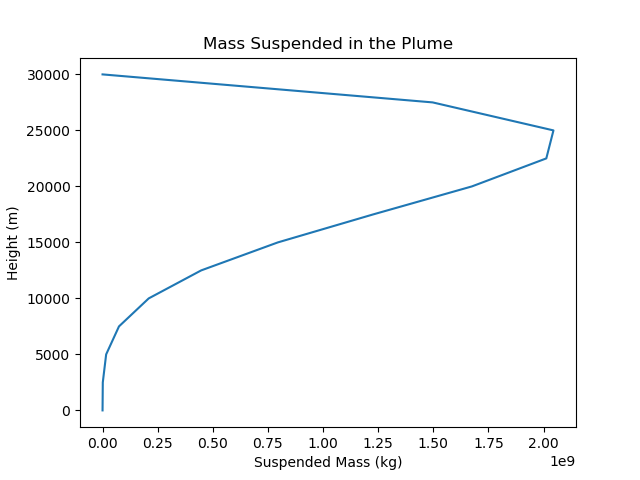

In [208]:
# Release points in column
z = np.linspace(z_min, z_max, p)

# Landing points of release point centers
x_bar = [landing_point(0, zk, u, v) for zk in z]

# Mass distribution in the plume

# Plume pdf
q_beta = beta(a,b)

#Mass distribution in the plume
q = mass_dist_in_plume(q_beta, z_min, z_max, z, tot_mass)

table = np.asarray([z, np.asarray(q), np.asarray(x_bar)]).T
display(pd.DataFrame(table,  columns=["Release Heights (z)", "Suspended Masses (q)", "Landing Points (x_bar)"]))

plt.figure()
plt.plot(q, z)
plt.title("Mass Suspended in the Plume")
plt.xlabel("Suspended Mass (kg)")
plt.ylabel("Height (m)")
plt.show()

<IPython.core.display.Javascript object>


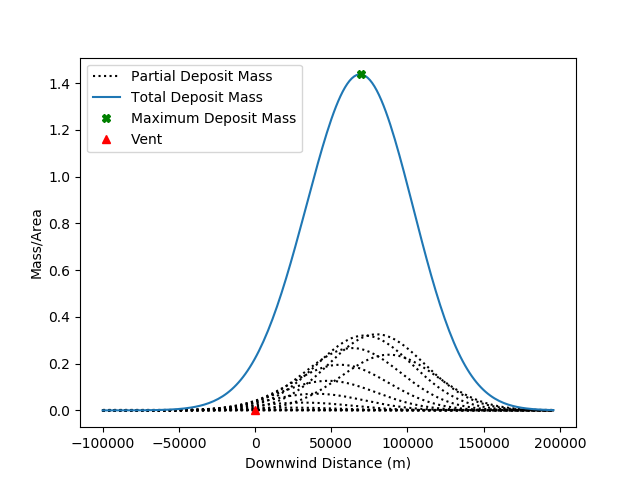

In [209]:
x_points = np.linspace(x_bar[0] - 100000, x_bar[-1] + 100000, 200)
plt.figure()
masses = []
for k in range(p):
    mass = q[k] * f(x_points, 0, s_sqr, x_bar[k], 0)
    masses.append(mass)
mass_tot = 0
for k in range(p):
    plt.plot(x_points, masses[k], "k:")
    mass_tot += masses[k]
plt.plot(x_points, masses[k], "k:", label="Partial Deposit Mass")
max_mass = max(mass_tot)
max_point = x_points[np.argmax(mass_tot)]
plt.plot(x_points, mass_tot, label="Total Deposit Mass")
plt.plot(max_point, max_mass, 'gX', label="Maximum Deposit Mass")
plt.plot(0, 0, 'r^', label="Vent")
plt.xlabel("Downwind Distance (m)")
plt.ylabel("Mass/Area")
plt.legend()
plt.show()

## Extending to 2D

The code blocks below extends the above principle into 2D by calculating the complete 2D mass deposit as a sum of partial masses.

In [210]:
xx = np.linspace(x_bar[0] - 100000, x_bar[-1] + 100000, 51)
x_range = xx[-1] - xx[0]
yy = np.linspace(-x_range/2, x_range/2, 51)
X, Y = np.meshgrid(xx, yy)
mass = np.zeros(X.shape)
levels = []
for k, zh in enumerate(z):
    # Gaussian dispersal
    gauss = f(X, Y, s_sqr, x_bar[k], y_bar=0)
    sus_gauss = f(X, Y, s_sqr, 0, y_bar=0)
    mass += gauss*q[k]
    levels.append(sus_gauss*q[k])


<IPython.core.display.Javascript object>


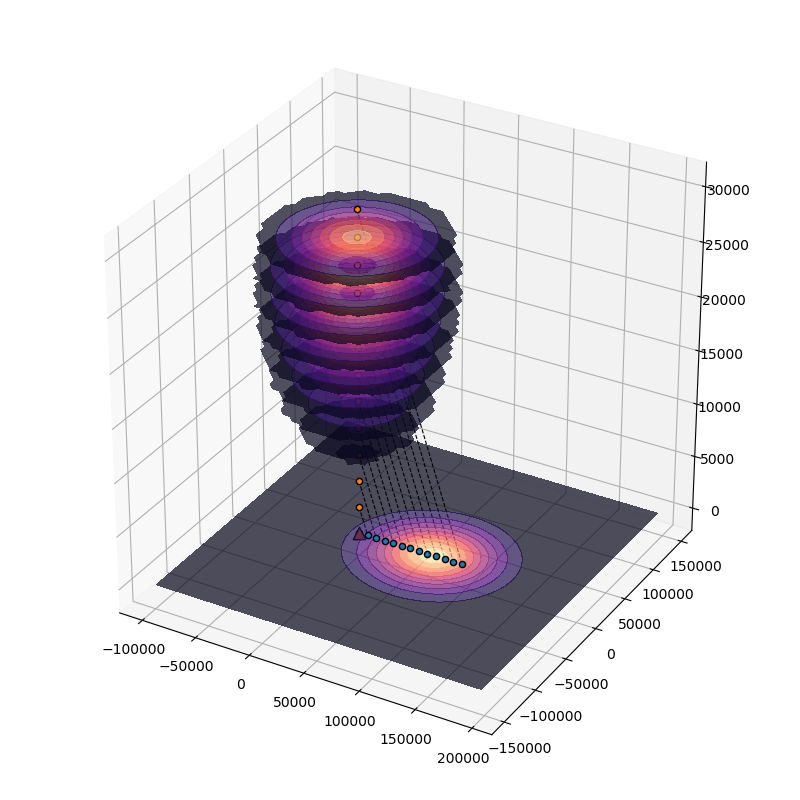

c:\users\nmostert\envs\spew\lib\site-packages\matplotlib\contour.py:1480: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
c:\users\nmostert\envs\spew\lib\site-packages\matplotlib\contour.py:1481: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


In [211]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
im=ax.contourf(X, Y, mass, 10, cmap="magma", alpha=0.7)

i = 0
for zh, xb in zip(z, x_bar):
    xline = np.linspace(0, xb, 100)
    pt = traj(xline, v, u, 0, zh)
    sp = ax.plot(xline, [0]*len(xline),  pt, "k--", lw=.8)
    ax.scatter(xb, 0, 0, c='C0', edgecolors='k')
    ax.scatter(0, 0, zh, c='C1', edgecolors='k')
    level_mass = levels[i]
    level_mass[level_mass < 0.01] = None
    ax.contourf(X, Y, level_mass*5, levels=np.linspace(0, np.max(mass), 10), cmap="magma", offset=zh, alpha=0.7, vmin=0, vmax=np.max(mass), extend='min')
    i += 1
ax.set_aspect('equal', 'box')
ax.scatter(0, 0, 0, marker="^", edgecolor='k', c='C1', s=80)

plt.tight_layout()

## Creating to 2D Sample

The sampling distribution is calculated with the sample mean at the point of maximum deposit mass. 

Here, the sample variance is taken as the diffusion coefficient. 


In [242]:
samp_mean = [max_point, 0]
samp_cov = [[5*s_sqr, 0], [0, s_sqr]]
samp_x, samp_y = np.random.multivariate_normal(samp_mean, samp_cov, p).T

<IPython.core.display.Javascript object>


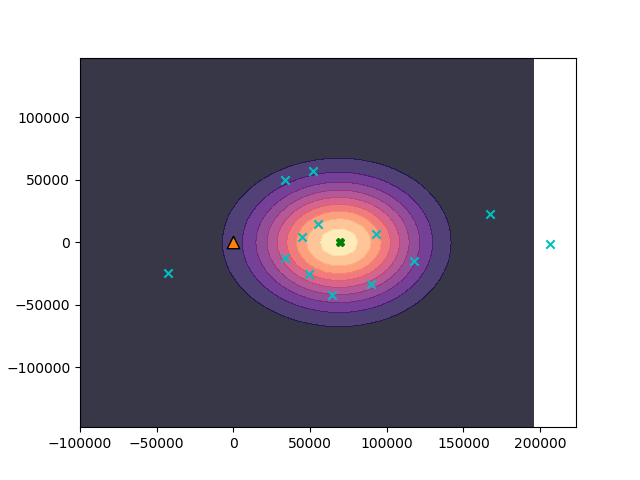

In [243]:
plt.figure()
plt.contourf(X, Y, mass, 10, cmap="magma", alpha=0.8)
plt.scatter(0, 0, marker="^", edgecolor='k', c='C1', s=80)
plt.scatter(samp_x, samp_y, marker='x', c='c')
plt.plot(max_point, 0, 'gX')
plt.show()

Here, the mass is calculated at each sample point. 

In [244]:
table = np.asarray([samp_x, samp_y]).T
display(pd.DataFrame(table, columns=["X", "Y"]))

n = p
a = np.zeros((n,p))
for i in range(n):
    for k in range(p):
        a[i,k] = f(samp_x[i], samp_y[i], s_sqr, x_bar[k], 0)
display(pd.DataFrame(a))
m = np.matmul(a, q)
display(pd.DataFrame(m, columns=["Mass"]))

,X,Y
0,-42650.799831,-24592.831357
1,89541.527278,-33379.355041
2,167418.373320,22947.232672
3,117791.319823,-14752.260287
4,49526.046230,-25403.087546
5,93144.402902,6398.269576
6,64161.250159,-41788.840818
7,33378.874345,49627.805023
8,33653.869485,-12334.444509
9,206152.988258,-1427.144025


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,4.736716e-11,3.264854e-11,2.111558e-11,1.281431e-11,7.296926e-12,3.898860e-12,1.954736e-12,9.195839e-13,4.059265e-13,1.681343e-13,6.534584e-14,2.383046e-14,8.154544e-15
1,1.655238e-12,3.275734e-12,6.082885e-12,1.059896e-11,1.732886e-11,2.658455e-11,3.826850e-11,5.168998e-11,6.551249e-11,7.791026e-11,8.693967e-11,9.103201e-11,8.943821e-11
2,1.002478e-16,3.692966e-16,1.276523e-15,4.140326e-15,1.260066e-14,3.598363e-14,9.642049e-14,2.424301e-13,5.719480e-13,1.266133e-12,2.629996e-12,5.126057e-12,9.374858e-12
3,1.385763e-13,3.435785e-13,7.993110e-13,1.744851e-12,3.573993e-12,6.869131e-12,1.238804e-11,2.096315e-11,3.328611e-11,4.959323e-11,6.933212e-11,9.094932e-11,1.119482e-10
4,3.381164e-11,4.862461e-11,6.561435e-11,8.307958e-11,9.870577e-11,1.100382e-10,1.151059e-10,1.129807e-10,1.040552e-10,8.992407e-11,7.291906e-11,5.548287e-11,3.961226e-11
5,2.036982e-12,4.148774e-12,7.928756e-12,1.421815e-11,2.392402e-11,3.777268e-11,5.595957e-11,7.778999e-11,1.014672e-10,1.241883e-10,1.426226e-10,1.536912e-10,1.554041e-10
6,8.485778e-12,1.371495e-11,2.079934e-11,2.959768e-11,3.952016e-11,4.951450e-11,5.821018e-11,6.421231e-11,6.646461e-11,6.455285e-11,5.882923e-11,5.030646e-11,4.036520e-11
7,2.661152e-11,3.364400e-11,3.991154e-11,4.442651e-11,4.640221e-11,4.547659e-11,4.182057e-11,3.608651e-11,2.921814e-11,2.219796e-11,1.582436e-11,1.058504e-11,6.643718e-12
8,8.372331e-11,1.060809e-10,1.261192e-10,1.406947e-10,1.472743e-10,1.446536e-10,1.333166e-10,1.152901e-10,9.355186e-11,7.123047e-11,5.088994e-11,3.411543e-11,2.145965e-11
9,9.393456e-20,4.713524e-19,2.219315e-18,9.804937e-18,4.064653e-17,1.581084e-16,5.770845e-16,1.976408e-15,6.351356e-15,1.915178e-14,5.418820e-14,1.438643e-13,3.583886e-13


,Mass
0,0.008479
1,0.690826
2,0.016950
3,0.472999
4,0.894786
5,1.104611
6,0.594896
7,0.253409
8,0.810860
9,0.000378


<IPython.core.display.Javascript object>


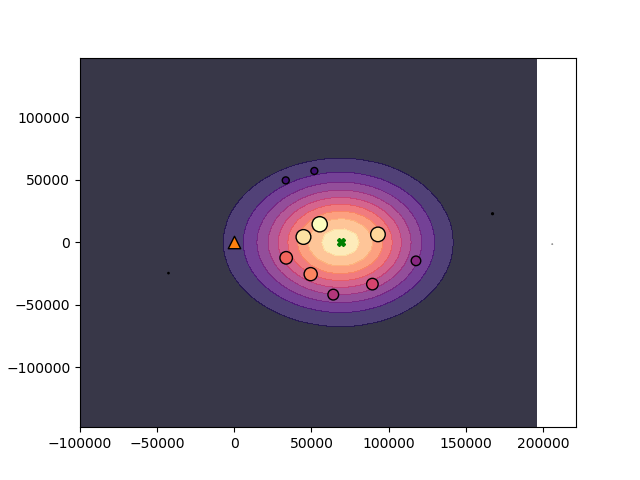

<IPython.core.display.Javascript object>


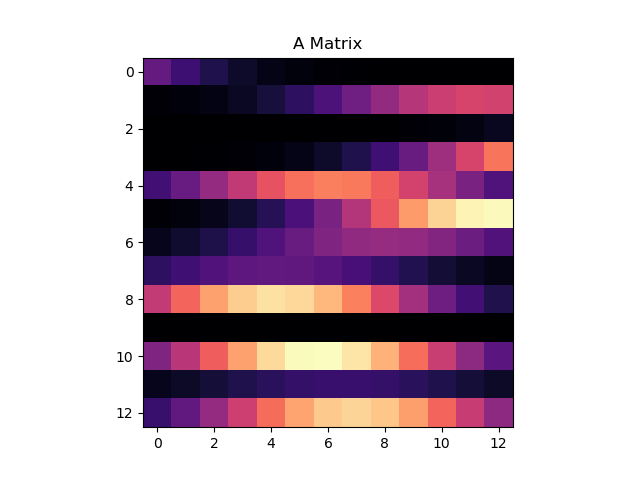

In [245]:
plt.figure()
plt.contourf(X, Y, mass, 10, cmap="magma", alpha=0.8)
plt.scatter(samp_x, samp_y, s=m*100, c=m*100, cmap="magma",edgecolor='k',)
plt.scatter(0, 0, marker="^", edgecolor='k', c='C1', s=80)
# plt.scatter(samp_x, samp_y, marker='x', c='c')
plt.plot(max_point, 0, 'gX')
plt.show()

plt.figure()
plt.imshow(a, cmap='magma')
plt.title("A Matrix")
plt.show()

## Inversion

Here, the inversion is performed, and residuals calculated.

,Height,Input Mass,Inverted Mass,Residual
0,0.0,0.000000e+00,4.906895e+03,-4906.895438
1,2500.0,1.124606e+06,1.087363e+06,37243.451816
2,5000.0,1.635791e+07,1.649302e+07,-135111.022903
3,7500.0,7.453073e+07,7.422059e+07,310145.675448
4,10000.0,2.093813e+08,2.098833e+08,-502001.379204
5,12500.0,4.472866e+08,4.466830e+08,603644.669471
6,15000.0,7.949945e+08,7.955473e+08,-552779.314780
7,17500.0,1.227355e+09,1.226966e+09,388155.478323
8,20000.0,1.675050e+09,1.675257e+09,-207214.093474
9,22500.0,2.012330e+09,2.012248e+09,81902.946018


<IPython.core.display.Javascript object>


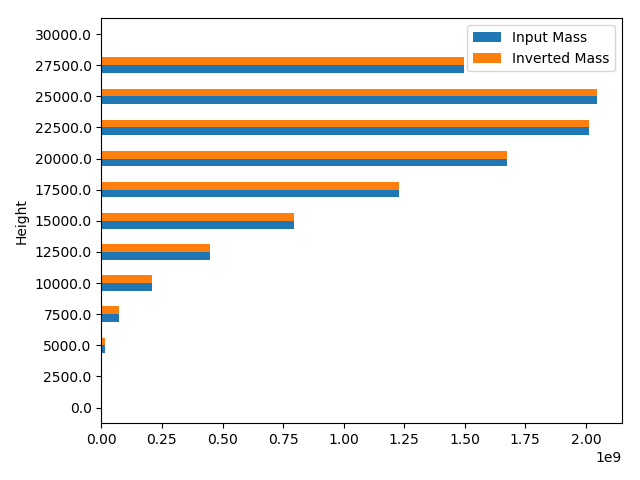

<IPython.core.display.Javascript object>


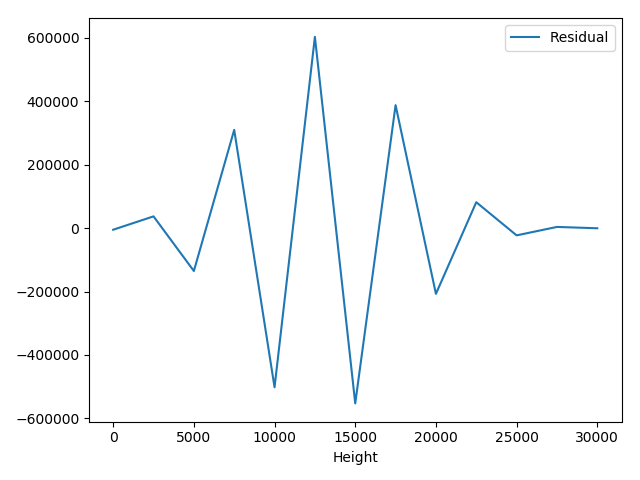

In [246]:
q_inv = np.linalg.solve(a, m)
res = q - q_inv
data = np.asarray([np.asarray(z), np.asarray(q), q_inv, res])
df = pd.DataFrame(data.T, columns=["Height", "Input Mass", "Inverted Mass", "Residual"])
display(df)

ax = df.plot.barh(x="Height", y=['Input Mass', 'Inverted Mass'], rot=0)
plt.tight_layout()
df.plot(x="Height", y=['Residual'], rot=0)
plt.tight_layout()